In [24]:
%load_ext autoreload
%autoreload 2

In [79]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import torch
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

from inference.path import LinearConditionalProbabilityPath
from inference.distribution import Gaussian
from learning.train import ConditionalFlowMatchingTrainer
from learning.mlp import MLPVectorField

import numpy as np
import copy
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Define Theory

In [103]:
from inference.distribution import Sampleable

class Phi4(Sampleable):

    def __init__(self, L, k, l, burn_in=1000, device='cpu'):
        ''' 
        Initalize Phi4 model with grid size L, coupling constant k, and self-coupling constant l.
        '''
        self.L = L
        self.k = k
        self.l = l
        self.device = device

        self._current_phi = torch.randn(L, L).to(device)
        self._current_action = self.get_action(self._current_phi)
        self.sample(num_samples=burn_in) # Sets self._current_phi via burn-in time.
    
    @property
    def dim(self):
        return self.L**2

    def get_action(self, phi):
        return torch.sum(-2 * self.k * phi * (torch.roll(phi, 1, 0) + torch.roll(phi, 1, 1))
                    + (1 - 2 * self.l) * phi**2 
                    + self.l * phi**4)

    def get_drift(self, phi):
        return (2 * self.k * (torch.roll(phi, 1, -1) + torch.roll(phi, -1, -1)
                        + torch.roll(phi, 1, -2) + torch.roll(phi, -1, -2))
                + 2 * phi * (2 * self.l * (1 - phi**2) - 1))

    def get_hamiltonian(self, chi, action):
        return 0.5 * torch.sum(chi**2) + action

    def sample(self,
               num_samples: int = 1000, 
               hmc_steps: int = 100,
               n_thin: int = 1):
        '''
        Sample from the Phi4 model using the HMC algorithm.

        Args:
            phi_0: Initial configuration to start the HMC chain.
            num_samples: Number of samples to draw.
            hmc_steps: Number of steps to run the HMC chain.
            n_thin: Number of steps to thin the samples.

        Returns:
        '''
        # Initialize phi, get associated action
        phi = self._current_phi
        S = self.get_action(phi)

        # Sample
        cfgs = []

        total_iterations = num_samples * n_thin
        for i in tqdm(range(total_iterations)):
            phi, S, accepted = self._sampling_step(phi, S, hmc_steps=hmc_steps)
            
            if i % n_thin == 0: # Only record every n_thin steps.
                cfgs.append(copy.deepcopy(phi))
                
        cfgs = torch.stack(cfgs).reshape(-1, self.dim)
        self._current_phi = phi
        return cfgs
        
    
    def _sampling_step(self, phi_0, S_0, hmc_steps=100):
        """
        Propose one step of the HMC chain, using HMC algorithm.
        """
        dt = 1 / hmc_steps

        phi = phi_0
        chi = torch.randn(*phi.shape, device=self.device)
        H_0 = self.get_hamiltonian(chi, S_0)

        chi += 0.5 * dt * self.get_drift(phi)
        for i in range(hmc_steps-1):
            phi += dt * chi
            chi += dt * self.get_drift(phi)
        phi += dt * chi
        chi += 0.5 * dt * self.get_drift(phi)

        S = self.get_action(phi)
        dH = self.get_hamiltonian(chi, S) - H_0

        if dH > 0:
            if torch.rand(1, device=self.device) >= torch.exp(-dH):
                return phi_0, S_0, False
        return phi, S, True

# Sampling Scheme

100%|██████████| 1000/1000 [00:02<00:00, 434.18it/s]

torch.Size([100, 1024])


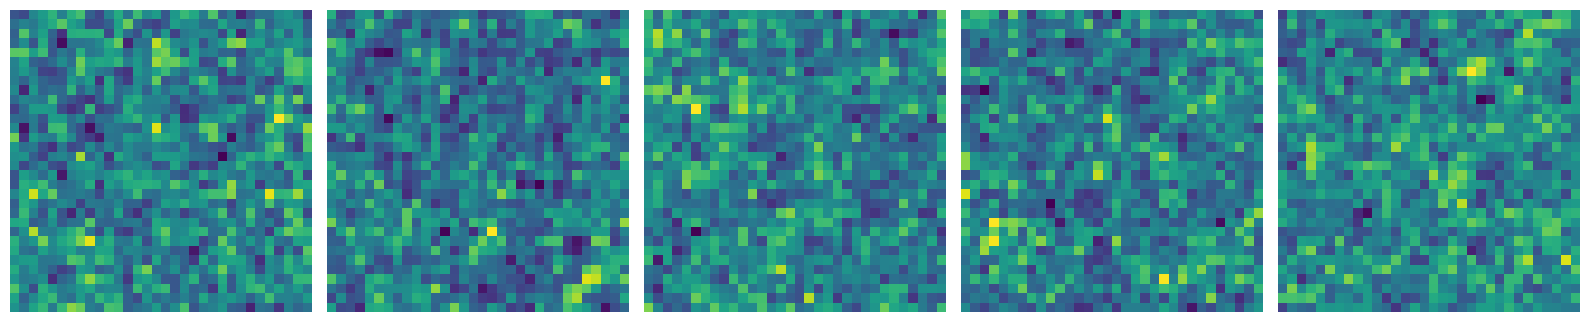

In [ ]:
L = 32
k = 0.3
l = 0.02

phi4 = Phi4(L, k, l)
cfgs = phi4.sample(num_samples=1000, hmc_steps=100, n_thin=10)
print(cfgs.shape)
cfgs = cfgs.reshape(-1, L, L).detach().cpu().numpy()

# Plot 5 random configurations
fig, axes = plt.subplots(1, 5, figsize=(16, 6))  # Switched figsize to match 1 row, 5 columns
i=  10
for i, id in enumerate([1,2,3,4,5]):
    axes[i].imshow(cfgs[id], cmap='viridis')  # You can change cmap as needed
    axes[i].axis('off')  # Optional: remove axes for cleaner look
plt.tight_layout()
plt.show()

## Test Statistics

In [89]:
def jackknife(samples: np.ndarray):
    """Return mean and estimated lower error bound."""
    means = []

    for i in range(samples.shape[0]):
        means.append(np.delete(samples, i, axis=0).mean(axis=0))

    means = np.asarray(means)
    mean = means.mean(axis=0)
    error = np.sqrt((samples.shape[0] - 1) * np.mean(np.square(means - mean), axis=0))
    
    return mean, error

In [90]:
def get_mag(cfgs: np.ndarray):
    """Return mean and error of magnetization."""
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    return jackknife(cfgs.mean(axis=axis))

def get_abs_mag(cfgs: np.ndarray):
    """Return mean and error of absolute magnetization."""
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    return jackknife(np.abs(cfgs.mean(axis=axis)))

def get_chi2(cfgs: np.ndarray):
    """Return mean and error of suceptibility."""
    V = np.prod(cfgs.shape[1:])
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    mags = cfgs.mean(axis=axis)
    return jackknife(V * (mags**2 - mags.mean()**2))

def get_corr_func(cfgs: np.ndarray):
    """Return connected two-point correlation function with errors for symmetric lattices."""
    mag_sq = np.mean(cfgs)**2
    corr_func = []
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])

    for i in range(1, cfgs.shape[1], 1):
        corrs = []

        for mu in range(len(cfgs.shape)-1):
            corrs.append(np.mean(cfgs * np.roll(cfgs, i, mu+1), axis=axis))

        corrs = np.array(corrs).mean(axis=0)
        corr_mean, corr_err = jackknife(corrs - mag_sq)
        corr_func.append([i, corr_mean, corr_err])

    return np.array(corr_func)

M = 2.1941 +/- 0.0038
|M| = 2.1941 +/- 0.0038
chi2 = 1.4907 +/- 17.2219


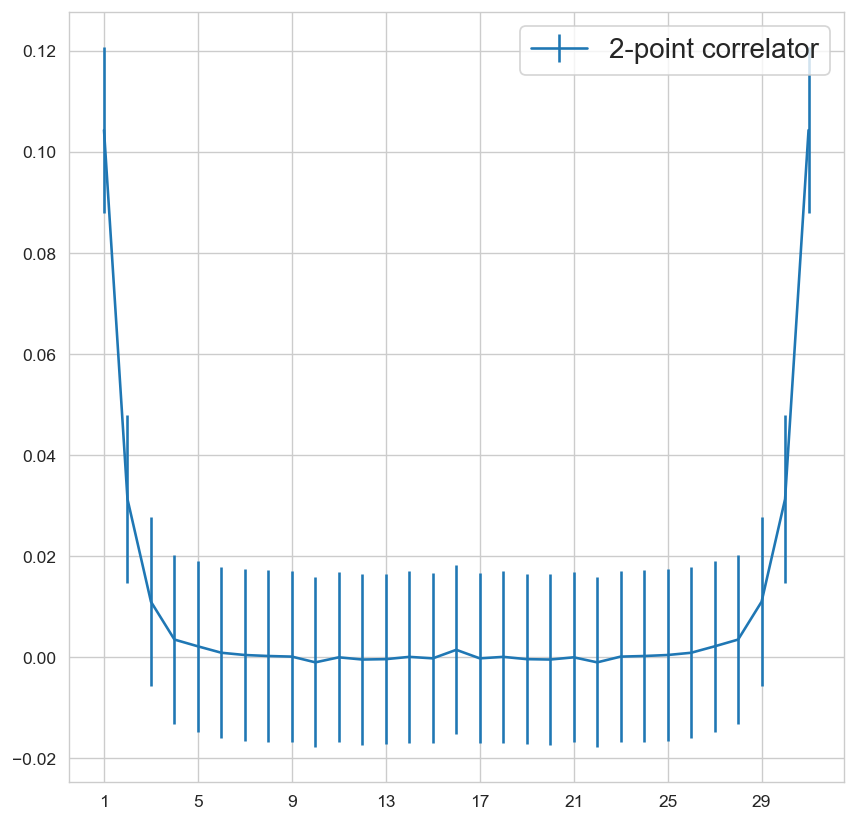

In [91]:
# Magnetization and Derivative
M, M_err = get_mag(cfgs)
M_abs, M_abs_err = get_abs_mag(cfgs)
chi2, chi2_err = get_chi2(cfgs)

print("M = %.4f +/- %.4f" % (M, M_err))
print("|M| = %.4f +/- %.4f" % (M_abs, M_abs_err))
print("chi2 = %.4f +/- %.4f" % (chi2, chi2_err))

# 2 Point Function
corr_func = get_corr_func(cfgs)

fig, ax = plt.subplots(1,1, dpi=125, figsize=(8,8))
plt.xticks([i for i in range(1, L, 4)])
ax.errorbar(corr_func[:,0], corr_func[:,1], yerr=corr_func[:,2], label='2-point correlator')
plt.legend(prop={'size': 16})
plt.show()

# Train Neural Network

In [ ]:
# Construct conditional probability path
L = 8

theory = Phi4(L, k, l, device='cpu')
dim = theory.dim
path = LinearConditionalProbabilityPath(
    p_simple = Gaussian.isotropic(dim=dim, std=1.0),
    p_data = theory,
    device = device
)

# Construct learnable vector field
linear_flow_model = MLPVectorField(dim=dim, hiddens=[64,64,64,64])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, linear_flow_model, device=device)
losses = trainer.train(num_epochs=10000, lr=1e-3, batch_size=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training: Epoch 0, loss: 0.6330:   0%|          | 17/10000 [00:40<6:41:09,  2.41s/it]